#Multi-Agent Path Finding (MAPF) problem

###Defining the Environment

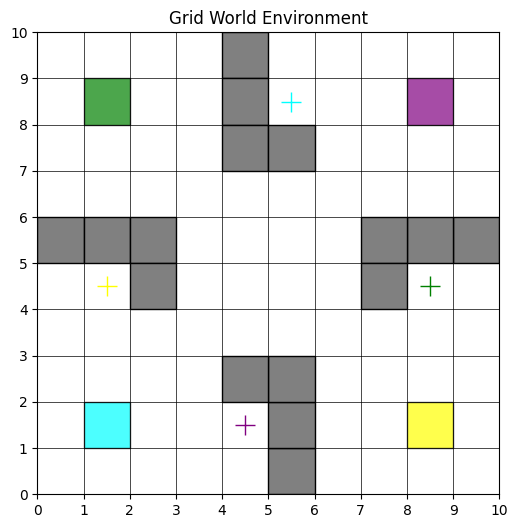

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class GridWorld:
    def __init__(self, grid_size, obstacles, agents):
        self.grid_size = grid_size
        self.obstacles = obstacles
        self.agents = agents
        self.num_agents = len(agents)
        self.state = [agents[agent]['start'] for agent in agents]  # List of agent positions
        self.destinations = [agents[agent]['goal'] for agent in agents]
        self.steps_taken = [0] * self.num_agents
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'STAY']
        self.grid = np.zeros(grid_size)
        self._place_obstacles()
        self._place_agents()

    def _place_obstacles(self):
        for obs in self.obstacles:
            self.grid[obs] = -1  # Represent obstacles with -1

    def _place_agents(self):
        for pos in self.state:
            self.grid[pos] = 1  # Represent agents with 1

    def is_valid_position(self, position):
        """
        Check if the given position is valid (within bounds and not an obstacle).
        """
        x, y = position
        return (
            0 <= x < self.grid_size[0]
            and 0 <= y < self.grid_size[1]
            and self.grid[position] != -1
        )

    def step(self, actions):
        """
        Executes actions for all agents and returns updated state, rewards, and done status.
        """
        next_state = list(self.state)  # Copy of current state
        rewards = []

        # Define movement for actions
        ACTIONS = {
            'UP': (-1, 0),
            'DOWN': (1, 0),
            'LEFT': (0, -1),
            'RIGHT': (0, 1),
            'STAY': (0, 0)
        }

        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            # Check if the new position is valid and not occupied by another agent
            if self.is_valid_position(new_pos) and new_pos not in next_state:
                next_state[i] = new_pos

            # Increment step count for the agent
            self.steps_taken[i] += 1

            # Assign reward based on whether the goal is reached or not
            if new_pos == self.destinations[i]:
                reward = 10  # Reached goal
            else:
                reward = -1  # Step penalty
            rewards.append(reward)

        # Update state
        self.state = tuple(next_state)

        # Check if all agents reached their goals
        done = all(next_state[i] == self.destinations[i] for i in range(self.num_agents))

        # Return updated state, rewards, done status, and max steps taken
        return self.state, rewards, done, max(self.steps_taken)

    def render(self):
        """
        Visualizes the grid and agent states.
        """
        visualize_grid(self.grid_size, self.obstacles, {'Agent' + str(i): {'pos': pos, 'goal': goal}
                                                        for i, (pos, goal) in enumerate(zip(self.state, self.destinations))})


# Visualization Function
def visualize_grid(grid_size, obstacles, state):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    ax.set_xticks(np.arange(0, grid_size[1] + 1, 1))
    ax.set_yticks(np.arange(0, grid_size[0] + 1, 1))
    ax.grid(color='black', linestyle='-', linewidth=0.5)

    # Draw obstacles
    for obs in obstacles:
        rect = patches.Rectangle((obs[1], grid_size[0] - obs[0] - 1), 1, 1, linewidth=1, edgecolor='black', facecolor='gray')
        ax.add_patch(rect)

    # Draw agents and their goals
    agent_colors = ['green', 'purple', 'cyan', 'yellow']
    for i, agent in enumerate(state):
        pos = state[agent]['pos']
        goal = state[agent]['goal']

        # Agent's position
        rect = patches.Rectangle((pos[1], grid_size[0] - pos[0] - 1), 1, 1, linewidth=1, edgecolor='black', facecolor=agent_colors[i % len(agent_colors)], alpha=0.7)
        ax.add_patch(rect)

        # Agent's goal position
        ax.plot(goal[1] + 0.5, grid_size[0] - goal[0] - 0.5, marker='+', markersize=15, color=agent_colors[i % len(agent_colors)], linewidth=2)

    # Set aspect ratio
    ax.set_aspect('equal', adjustable='box')
    plt.title('Grid World Environment')
    plt.show()


# Define obstacles, agents, and goals
obstacles = [(4, 0), (4, 1), (4, 2), (5, 2), (0, 4), (1, 4), (2, 4), (2, 5),(9,5),(8,5),(7,5),(7,4),(4,9),(4,8),(4,7),(5,7)]
agents = {
    'A': {'start': (1, 1), 'goal': (5, 8)},
    'B': {'start': (1, 8), 'goal': (8, 4)},
    'C': {'start': (8, 1), 'goal': (1, 5)},
    'D': {'start': (8, 8), 'goal': (5, 1)}
}

# Initialize environment and render it
env = GridWorld((10, 10), obstacles, agents)
env.render()


### Training on Q-Learning Based Approach

In [23]:
from collections import defaultdict

# Constants
GAMMA = 0.85  # Discount factor
ALPHA = 0.1  # Learning rate
EPSILON = 0.2  # Exploration rate
MAX_EPISODES = 1000
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'STAY']
NUM_ACTIONS = len(ACTIONS)

# Train Q-learning agents
def train_agents(env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(env.num_agents)]
    min_max_time = float('inf')  # Track minimum maximum time

    for episode in range(MAX_EPISODES):
        state = env.reset()  # Reset the environment
        done = False

        while not done:
            actions = []
            for i in range(env.num_agents):
                # Choose action using epsilon-greedy policy
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)  # Explore
                else:
                    action = np.argmax(q_tables[i][state[i]])  # Exploit
                actions.append(action)

            # Execute actions in the environment
            next_state, rewards, done, max_steps = env.step([ACTIONS[a] for a in actions])

            # Update Q-values
            for i in range(env.num_agents):
                current_q = q_tables[i][state[i]][actions[i]]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )

            # Move to next state
            state = next_state

        # Update minimum max steps
        min_max_time = min(min_max_time, max_steps)

        # Optional: Print progress
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{MAX_EPISODES}, Min-Max Steps: {min_max_time}")

    return q_tables, min_max_time

# Add reset method to the GridWorld class
def reset(self):
    self.state = [self.agents[agent]['start'] for agent in self.agents]
    self.steps_taken = [0] * self.num_agents
    return self.state

# Attach reset method dynamically
setattr(GridWorld, "reset", reset)

# Initialize and train
env = GridWorld((10, 10), obstacles, agents)
q_tables, min_max_time = train_agents(env)

print(f"\nTraining completed. Minimum maximum time: {min_max_time}")

# Visualize learned policy
def visualize_policy(env, q_tables):
    for agent_idx, agent in enumerate(env.agents):
        print(f"\nPolicy for Agent {agent}:")
        state = env.agents[agent]['start']
        while state != env.agents[agent]['goal']:
            action = np.argmax(q_tables[agent_idx][state])
            print(f"State: {state}, Action: {ACTIONS[action]}")
            move = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1), 'STAY': (0, 0)}
            state = (state[0] + move[ACTIONS[action]][0], state[1] + move[ACTIONS[action]][1])

# Display the learned policy
visualize_policy(env, q_tables)

Episode 50/1000, Min-Max Steps: 48
Episode 100/1000, Min-Max Steps: 18
Episode 150/1000, Min-Max Steps: 17
Episode 200/1000, Min-Max Steps: 16
Episode 250/1000, Min-Max Steps: 16
Episode 300/1000, Min-Max Steps: 16
Episode 350/1000, Min-Max Steps: 16
Episode 400/1000, Min-Max Steps: 15
Episode 450/1000, Min-Max Steps: 15
Episode 500/1000, Min-Max Steps: 15
Episode 550/1000, Min-Max Steps: 15
Episode 600/1000, Min-Max Steps: 15
Episode 650/1000, Min-Max Steps: 15
Episode 700/1000, Min-Max Steps: 15
Episode 750/1000, Min-Max Steps: 13
Episode 800/1000, Min-Max Steps: 13
Episode 850/1000, Min-Max Steps: 13
Episode 900/1000, Min-Max Steps: 13
Episode 950/1000, Min-Max Steps: 13
Episode 1000/1000, Min-Max Steps: 13

Training completed. Minimum maximum time: 13

Policy for Agent A:
State: (1, 1), Action: DOWN
State: (2, 1), Action: RIGHT
State: (2, 2), Action: DOWN
State: (3, 2), Action: RIGHT
State: (3, 3), Action: RIGHT
State: (3, 4), Action: RIGHT
State: (3, 5), Action: RIGHT
State: (3, 6

### Visualizing the trained Path on the maze

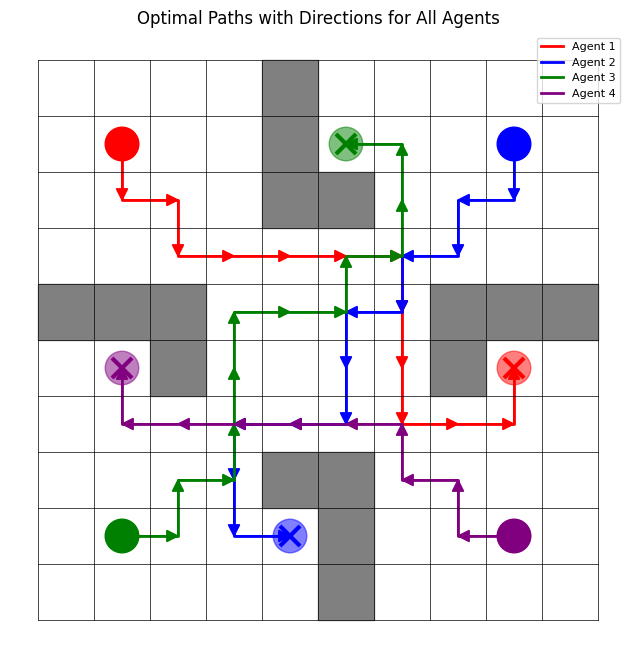

In [24]:
def visualize_optimal_paths_with_arrows(grid_size, env, q_tables):
    """
    Visualize the grid with optimal paths for all agents, including arrows for direction.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    agent_colors = ['red', 'blue', 'green', 'purple']

    # Draw the grid
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            if (x, y) in env.obstacles:
                ax.add_patch(patches.Rectangle((y, grid_size[0] - x - 1), 1, 1, color='gray'))  # Obstacles

    # Draw goals for each agent
    for i, goal in enumerate(env.destinations):
        ax.plot(
            goal[1] + 0.5,
            grid_size[0] - goal[0] - 1 + 0.5,
            marker='x',
            color=agent_colors[i % len(agent_colors)],
            markersize=15,
            markeredgewidth=3,
        )

    # Compute and visualize paths for each agent
    for i, agent in enumerate(env.agents):
        current_pos = env.agents[agent]['start']
        goal = env.agents[agent]['goal']
        path_x, path_y = [], []

        path_x.append(current_pos[1] + 0.5)
        path_y.append(grid_size[0] - current_pos[0] - 1 + 0.5)

        while current_pos != goal:
            best_action_index = np.argmax(q_tables[i][current_pos])
            action = ACTIONS[best_action_index]
            move = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1), 'STAY': (0, 0)}[action]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if env.is_valid_position(next_pos):
                # Add arrow for direction
                ax.arrow(
                    current_pos[1] + 0.5,
                    grid_size[0] - current_pos[0] - 1 + 0.5,
                    move[1] * 0.8,  # Scaled to fit inside the grid
                    -move[0] * 0.8,  # Negative because of grid's flipped y-axis
                    head_width=0.2,
                    head_length=0.2,
                    fc=agent_colors[i % len(agent_colors)],
                    ec=agent_colors[i % len(agent_colors)],
                )
                current_pos = next_pos
                path_x.append(current_pos[1] + 0.5)
                path_y.append(grid_size[0] - current_pos[0] - 1 + 0.5)
            else:
                print(f"Invalid move encountered for Agent {i+1} at {current_pos}.")
                break

        # Plot the path for the agent
        ax.plot(path_x, path_y, color=agent_colors[i % len(agent_colors)], linestyle='-', linewidth=2, label=f'Agent {i+1}')
        ax.add_patch(patches.Circle((path_x[0], path_y[0]), 0.3, color=agent_colors[i % len(agent_colors)]))  # Start
        ax.add_patch(patches.Circle((path_x[-1], path_y[-1]), 0.3, color=agent_colors[i % len(agent_colors)], alpha=0.5))  # Goal

    # Add grid lines
    for i in range(grid_size[0] + 1):
        ax.plot([0, grid_size[1]], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, grid_size[1]], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    ax.legend(loc='upper right', fontsize=8)
    plt.title("Optimal Paths with Directions for All Agents")
    plt.show()


# Call the visualization function
visualize_optimal_paths_with_arrows(env.grid_size, env, q_tables)

### Bonus Question (Randomized Starting Point)

In [34]:
import random

# Q-learning Parameters
GAMMA = 0.9  # Discount factor
ALPHA = 0.1  # Learning rate
EPSILON = 0.1  # Exploration rate
MAX_EPISODES = 1000  # Reduced for quicker execution
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'STAY']
NUM_ACTIONS = len(ACTIONS)

# Q-learning with MAPF
def train_agents_gridworld(env):
    # Initialize Q-tables for each agent
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(env.num_agents)]
    min_max_steps = float('inf')  # To track the shortest episode

    for episode in range(MAX_EPISODES):
        state = env.reset()  # Randomize starting positions
        done = False
        steps = 0

        while not done:
            actions = []
            for i in range(env.num_agents):
                # ε-greedy action selection
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)  # Explore
                else:
                    action = np.argmax(q_tables[i][state[i]])  # Exploit
                actions.append(ACTIONS[action])

            next_state, rewards, done, max_steps = env.step(actions)

            # Update Q-values
            for i in range(env.num_agents):
                current_q = q_tables[i][state[i]][ACTIONS.index(actions[i])]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][ACTIONS.index(actions[i])] += ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )

            state = next_state
            steps += 1

        min_max_steps = min(min_max_steps, steps)

    return q_tables, min_max_steps

# Train the agents in the GridWorld environment
q_tables, min_max_steps = train_agents_gridworld(env)

# Print the results
print(f"\nMinimum maximum steps achieved: {min_max_steps}")


Minimum maximum steps achieved: 13
